In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mp
import matplotlib.animation as animation
import IPython


MASS = 0.600 # mass of the quadrotor
INERTIA = 0.15 # inertia of the quadrotor
        
LENGTH = 0.2 # length of the quadrotor
        
GRAVITY=9.81 #gravity constant

DELTA_T = 0.01 #integration step
        
NUMBER_STATES = 6 # number of states
NUMBER_CONTROLS = 2 # number of controls
        
            
def get_next_state(z,u):
    """
    Inputs:
    z: state of the quadrotor as a numpy array (x, vx, y, vy, theta, omega)
    u: control as a numpy array (u1, u2)

    Output:
    the new state of the quadrotor as a numpy array
    """
    x = z[0]
    vx = z[1]
    y = z[2]
    vy = z[3]
    theta = z[4]
    omega = z[5]

    dydt = np.zeros([NUMBER_STATES,])
    dydt[0] = vx
    dydt[1] = (-(u[0] + u[1]) * np.sin(theta)) / MASS
    dydt[2] = vy
    dydt[3] = ((u[0] + u[1]) * np.cos(theta) - MASS * GRAVITY) / MASS
    dydt[4] = omega
    dydt[5] = (LENGTH * (u[0] - u[1])) / INERTIA

    z_next = z + dydt * DELTA_T

    return z_next


    
def simulate(z0, controller, horizon_length, disturbance = False):
    """
    This function simulates the quadrotor for horizon_length steps from initial state z0

    Inputs:
    z0: the initial conditions of the quadrotor as a numpy array (x, vx, y, vy, theta, omega)
    controller: a function that takes a state z as argument and index i of the time step and returns a control u
    horizon_length: the horizon length

    disturbance: if True will generate a random push every seconds during the simulation

    Output:
    t[time_horizon+1] contains the simulation time
    z[4, time_horizon+1] and u[2, time_horizon] containing the time evolution of states and control
    """
    
    t = np.zeros([horizon_length+1,])
    z=np.empty([NUMBER_STATES, horizon_length+1])
    z[:,0] = z0
    u=np.zeros([NUMBER_CONTROLS, horizon_length])
    for i in range(horizon_length):
        u[:,i] = controller(z[:,i],i)
        z[:,i+1] = get_next_state(z[:,i], u[:,i])
        if disturbance and np.mod(i,100)==0:
            dist = np.zeros([NUMBER_STATES, ])
            dist[1::2] = np.random.uniform(-1.,1,(3,))
            z[:,i+1] += dist
        t[i+1] = t[i] + DELTA_T
    return t, z, u
    
    
def animate_robot(x, u, dt = 0.01):
    """
    This function makes an animation showing the behavior of the quadrotor
    takes as input the result of a simulation (with dt=0.01s)
    """

    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(np.round(min_dt * 1000))
    else:
        steps = 1
        use_dt = int(np.round(dt * 1000))

    #what we need to plot
    plotx = x[:,::steps]
    plotx = plotx[:,:-1]
    plotu = u[:,::steps]

    fig = mp.figure.Figure(figsize=[8.5,8.5])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4,4], ylim=[-4,4])
    ax.grid()

    list_of_lines = []

    #create the robot
    # the main frame
    line, = ax.plot([], [], 'k', lw=6)
    list_of_lines.append(line)
    # the left propeller
    line, = ax.plot([], [], 'b', lw=4)
    list_of_lines.append(line)
    # the right propeller
    line, = ax.plot([], [], 'b', lw=4)
    list_of_lines.append(line)
    # the left thrust
    line, = ax.plot([], [], 'r', lw=1)
    list_of_lines.append(line)
    # the right thrust
    line, = ax.plot([], [], 'r', lw=1)
    list_of_lines.append(line)

    def _animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])

        theta = plotx[4,i]
        x = plotx[0,i]
        y = plotx[2,i]
        trans = np.array([[x,x],[y,y]])
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        main_frame = np.array([[-LENGTH, LENGTH], [0,0]])
        main_frame = rot @ main_frame + trans 

        left_propeller = np.array([[-1.3 * LENGTH, -0.7*LENGTH], [0.1,0.1]])
        left_propeller = rot @ left_propeller + trans

        right_propeller = np.array([[1.3 * LENGTH, 0.7*LENGTH], [0.1,0.1]])
        right_propeller = rot @ right_propeller + trans

        left_thrust = np.array([[LENGTH, LENGTH], [0.1, 0.1+plotu[0,i]*0.04]])
        left_thrust = rot @ left_thrust + trans

        right_thrust = np.array([[-LENGTH, -LENGTH], [0.1, 0.1+plotu[0,i]*0.04]])
        right_thrust = rot @ right_thrust + trans

        list_of_lines[0].set_data(main_frame[0,:], main_frame[1,:])
        list_of_lines[1].set_data(left_propeller[0,:], left_propeller[1,:])
        list_of_lines[2].set_data(right_propeller[0,:], right_propeller[1,:])
        list_of_lines[3].set_data(left_thrust[0,:], left_thrust[1,:])
        list_of_lines[4].set_data(right_thrust[0,:], right_thrust[1,:])

        return list_of_lines

    def _init():
        return _animate(0)


    ani = animation.FuncAnimation(fig, _animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=_init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [2]:
def get_linearization(z,u):
    #initializing A and B
    
    A=np.identity(6)
    A[0,1]=DELTA_T
    A[1,4]=-(1/MASS)*(u[0]+u[1])*np.cos(z[4])*DELTA_T
    A[2,3]=DELTA_T
    A[3,4]=-(1/MASS)*(u[0]+u[1])*np.sin(z[4])*DELTA_T
    A[4,5]=DELTA_T
    
    
    B=np.zeros(shape=(6,2))
    B[1,0]=-np.sin(z[4])*DELTA_T/MASS
    B[1,1]=-(np.sin(z[4])*DELTA_T)/MASS
    B[3,0]=(np.cos(z[4])*DELTA_T)/MASS
    B[3,1]=(np.cos(z[4])*DELTA_T)/MASS
    B[-1,0]=LENGTH*DELTA_T/INERTIA
    B[-1,1]=-LENGTH*DELTA_T/INERTIA

    return A,B

In [3]:
def solve_LQR_trajectory(A, B, Q, R, x_bar, N):
  
    K_gains = []
    k_feedforward = []

    p=[]
    P=[]
    
    
    
    for i in range(N+1):
        if i==0:
            P.append(Q)
            qn=-Q.dot(x_bar[:,N])
            p.append(qn)
        else:
            Kn=-1.0 * np.linalg.inv(R+B.transpose().dot(P[i-1]).dot(B)).dot(B.transpose()).dot(P[i-1]).dot(A)
            Pn = Q + A.transpose().dot(P[i-1]).dot(A) + A.transpose().dot(P[i-1]).dot(B).dot(Kn)
            kn=-1.0 * np.linalg.inv(R+B.transpose().dot(P[i-1]).dot(B)).dot(B.transpose()).dot(p[i-1])
            pn=-Q.dot(x_bar[:,N-i])+A.transpose().dot(p[i-1])+A.transpose().dot(P[i-1]).dot(B).dot(kn)
            P.append(Pn)
            p.append(pn)
            K_gains.append(Kn)
            k_feedforward.append(kn)
    
    return K_gains[::-1], k_feedforward[::-1]

In [8]:
N = 1000 
x_bar=np.zeros([6,N+1]) 
for j in range(N+1):
    mat_valus=np.array([np.cos((2*np.pi)*j/N), 0, np.sin((2*np.pi)*j/N),0, 0, 0])
    x_bar[:,j] =np.transpose(mat_valus)

In [9]:
def circle_trajectory(current,i):
    
    z_star,u_star = np.transpose(np.array([0,0,0,0,0,0])),np.transpose(np.array([(2.983), (2.983)]))
    
    A, B = get_linearization(x_bar[:,i], u_star)


    Q=np.diag([105,0.75,105,0.75,105,0.75]) 
    R=np.diag([0.09,0.09]) 
    K, k = solve_LQR_trajectory(A, B, Q, R, x_bar, N)
    u = K[i].dot(current) + k[i] + u_star
    
    return u

In [ ]:
z_s = np.transpose(np.array([1,0,0,0,0,0]))
t,state,u=simulate(z_s,circle_trajectory,horizon_length=1000,disturbance=False)
animate_robot(state,u)

Text(0.5, 0, 'Time [s]')

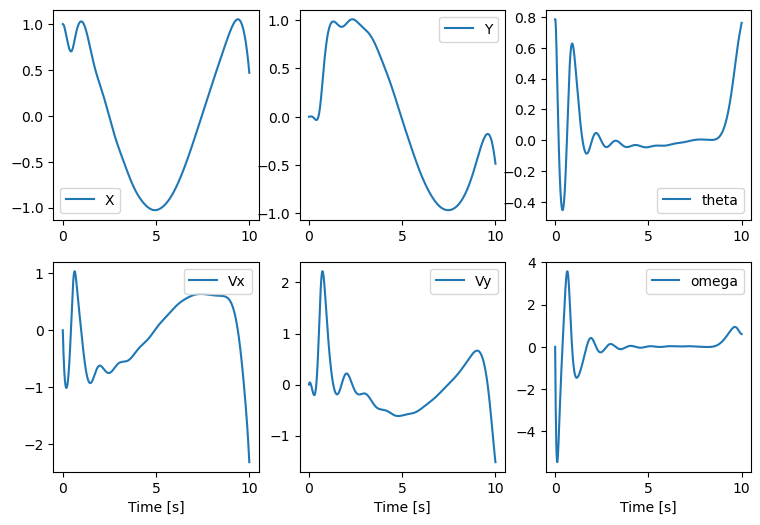

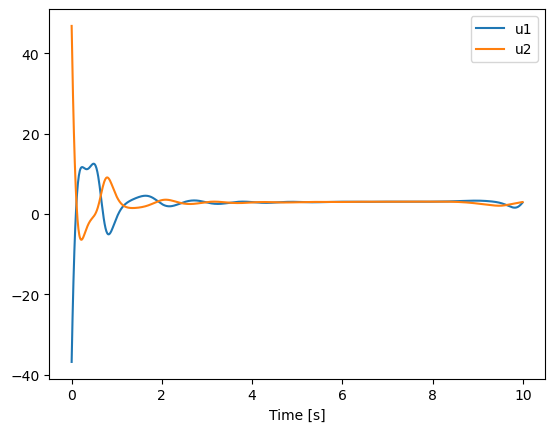

In [7]:
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')
